# 수정사항

레이어의 층을 3개 층으로 변경.
(layer 개수: 128로 통일, Dropout: 0.03)


In [1]:
# 데이터 불러오기
import pandas as pd
train = pd.read_csv('../Data/orb_data/train.csv', index_col=0)
test = pd.read_csv('../Data/orb_data/test.csv', index_col=0)
sample_submission = pd.read_csv('../Data/orb_data/sample_submission.csv', index_col=0)

In [2]:
# Train 데이터의 타입을 Sample_submission에 대응하는 가변수 형태로 변환
column_number = {}
for i, column in enumerate(sample_submission.columns):
    column_number[column] = i
    
def to_number(x, dic):
    return dic[x]

train['type_num'] = train['type'].apply(lambda x : to_number(x, column_number))

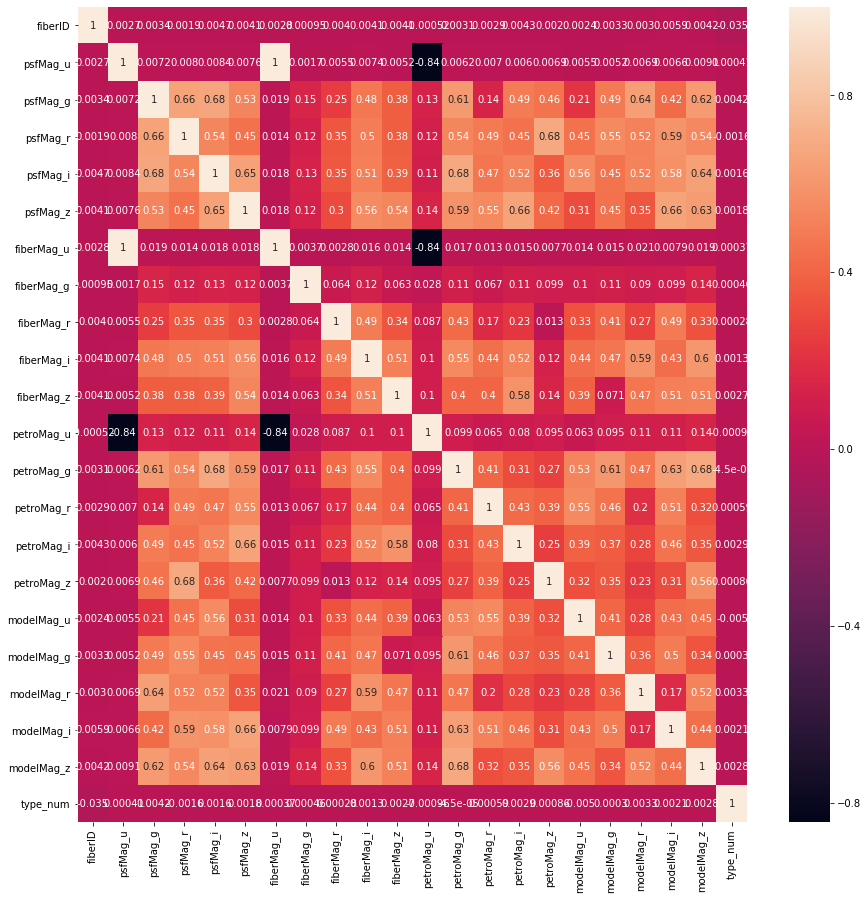

In [3]:
# 상관관계 파악을 위한 히트맵 그리기
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(15, 15))
sns.heatmap(data=train.corr(), annot=True)
plt.show()

In [4]:
# 모델에 적용할 데이터 셋 준비 
train_x = train.drop(columns=['type', 'type_num'], axis=1)
train_y = train['type_num']
test_x = test # (10009, 20)

In [5]:
# FiberID 행 지우기
del train_x['fiberID']
del test_x['fiberID']

In [6]:
train_x.columns

Index(['psfMag_u', 'psfMag_g', 'psfMag_r', 'psfMag_i', 'psfMag_z',
       'fiberMag_u', 'fiberMag_g', 'fiberMag_r', 'fiberMag_i', 'fiberMag_z',
       'petroMag_u', 'petroMag_g', 'petroMag_r', 'petroMag_i', 'petroMag_z',
       'modelMag_u', 'modelMag_g', 'modelMag_r', 'modelMag_i', 'modelMag_z'],
      dtype='object')

In [7]:
test_x.columns

Index(['psfMag_u', 'psfMag_g', 'psfMag_r', 'psfMag_i', 'psfMag_z',
       'fiberMag_u', 'fiberMag_g', 'fiberMag_r', 'fiberMag_i', 'fiberMag_z',
       'petroMag_u', 'petroMag_g', 'petroMag_r', 'petroMag_i', 'petroMag_z',
       'modelMag_u', 'modelMag_g', 'modelMag_r', 'modelMag_i', 'modelMag_z'],
      dtype='object')

In [8]:
# 훈련 데이터와 테스트 데이터로 나누기
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(train_x, train_y, test_size=0.2,  shuffle=True, random_state=0)

# One-Hot Encoding
from keras.utils import np_utils
y_train = np_utils.to_categorical(y_train)
y_test = np_utils.to_categorical(y_test)

Using TensorFlow backend.
/home/ubuntu/anaconda3/envs/tensorflow2_p36/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/ubuntu/anaconda3/envs/tensorflow2_p36/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/ubuntu/anaconda3/envs/tensorflow2_p36/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16

In [9]:
# 데이터 스케일
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
test_x = scaler.transform(test_x)

In [10]:
# gelu activation function -  Gaussian Error Linear Units (GELUs)
# https://arxiv.org/abs/1606.08415

import numpy as np
from keras.layers import Activation
from keras.utils.generic_utils import get_custom_objects
import tensorflow as tf
class Gelu(Activation):
    def __init__(self, activation, **kwargs):
        super(Gelu, self).__init__(activation, **kwargs)
        self.__name__='gelu'
        
def gelu(x):
    return 0.5 * x * (1 + tf.tanh(tf.sqrt(2 / np.pi) * (x + 0.044715 * tf.pow(x, 3))))

get_custom_objects().update({'gelu': Gelu(gelu)})
# gelu가 relu나 elu보다 성능이 좋다는 논문이 있어 사용합니다.

In [11]:
# 모델 구성
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization, Activation

model = Sequential()
model.add(Dense(128, input_shape=(20,)))
model.add(BatchNormalization())
model.add(Activation('gelu'))
model.add(Dropout(0.03))
model.add(Dense(128))
model.add(BatchNormalization())
model.add(Activation('gelu'))
model.add(Dropout(0.03))
model.add(Dense(128))
model.add(BatchNormalization())
model.add(Activation('gelu'))
model.add(Dropout(0.03))
model.add(Dense(19, activation='softmax'))

In [12]:
# 모델 요약
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 128)               2688      
_________________________________________________________________
batch_normalization_1 (Batch (None, 128)               512       
_________________________________________________________________
activation_1 (Activation)    (None, 128)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               16512     
_________________________________________________________________
batch_normalization_2 (Batch (None, 128)               512       
_________________________________________________________________
activation_2 (Activation)    (None, 128)              

In [13]:
# 조기 종료
from keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=100)

In [14]:
# 컴파일
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
# Adam optimizer default: keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)

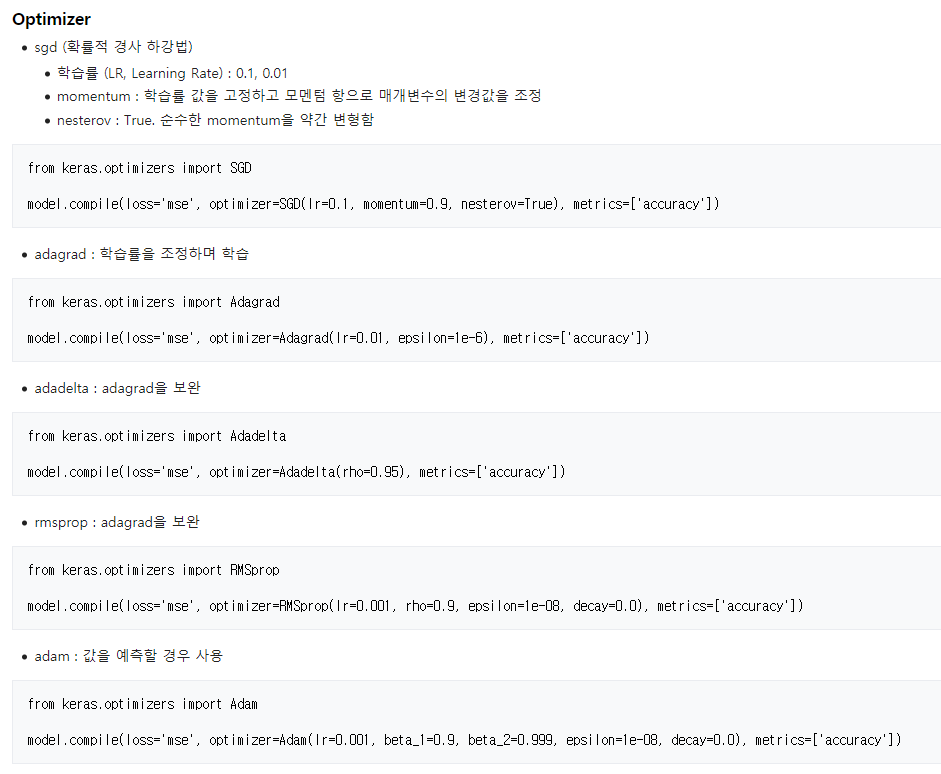

In [15]:
# 훈련
history = model.fit(X_train, y_train, validation_split=0.2, epochs=10000, batch_size=256, callbacks=[early_stopping]) # epochs number changeable

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Train on 127993 samples, validate on 31999 samples
Epoch 1/10000
127993/127993 [==============================] - 8s 66us/step - loss: 0.8167 - accuracy: 0.7554 - val_loss: 3.6504 - val_accuracy: 0.2494
Epoch 2/10000
127993/127993 [==============================] - 8s 59us/step - loss: 0.6382 - accuracy: 0.7927 - val_loss: 4.1272 - val_accuracy: 0.1298
Epoch 3/10000
127993/127993 [==============================] - 8s 59us/step - loss: 0.6052 - accuracy: 0.8000 - val_loss: 4.6900 - val_accuracy: 0.2095
Epoch 4/10000
127993/127993 [==============================] - 8s 59us/step - loss: 0.5881 - accuracy: 0.8028 - val_loss: 4.8660 - val_accuracy: 0.0681
Epoch 5/10000
127993/127993 [==============================] - 8s 59us/step - loss: 0.5703 - accuracy: 0.8099 - val_loss: 5.4172 - val_accuracy: 0.2505
Epoch 6/10000
127993/127993 [==============================] - 8s 59us/step - loss: 0.5626 - a

127993/127993 [==============================] - 8s 60us/step - loss: 0.4819 - accuracy: 0.8352 - val_loss: 8.0660 - val_accuracy: 0.2448
Epoch 51/10000
127993/127993 [==============================] - 8s 59us/step - loss: 0.4809 - accuracy: 0.8351 - val_loss: 8.2300 - val_accuracy: 0.0327
Epoch 52/10000
127993/127993 [==============================] - 8s 59us/step - loss: 0.4788 - accuracy: 0.8359 - val_loss: 8.3679 - val_accuracy: 0.0405
Epoch 53/10000
127993/127993 [==============================] - 8s 59us/step - loss: 0.4769 - accuracy: 0.8371 - val_loss: 8.0316 - val_accuracy: 0.0353
Epoch 54/10000
127993/127993 [==============================] - 8s 59us/step - loss: 0.4793 - accuracy: 0.8361 - val_loss: 8.6524 - val_accuracy: 0.1060
Epoch 55/10000
127993/127993 [==============================] - 8s 59us/step - loss: 0.4794 - accuracy: 0.8352 - val_loss: 8.4135 - val_accuracy: 0.0326
Epoch 56/10000
127993/127993 [==============================] - 8s 59us/step - loss: 0.4745 - acc

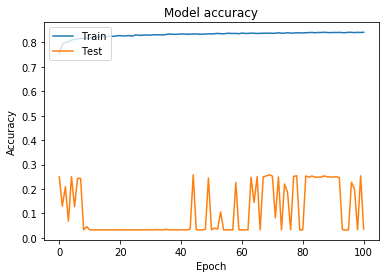

In [16]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

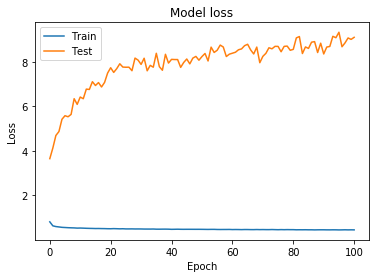

In [17]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [18]:
# 평가예측
loss, accuracy = model.evaluate(X_test, y_test, batch_size=256)
print('loss: ', loss)
print('accuracy: ', accuracy)

39999/39999 [==============================] - 2s 39us/step
loss:  9.11653579644297
accuracy:  0.03695092350244522


In [19]:
# Evaluating in optimal parameter
y_pred = model.predict(test_x)
print(y_pred)

[[1.0834006e-04 2.6136822e-06 1.6858363e-13 ... 4.2599185e-10
  4.3805034e-07 1.5682504e-04]
 [3.0877066e-04 7.9312247e-07 2.4169506e-14 ... 5.3141890e-11
  3.5139391e-07 1.8987674e-04]
 [2.6248783e-04 5.0470146e-07 9.9985285e-15 ... 3.1371170e-11
  3.8743548e-07 1.4055525e-04]
 ...
 [4.0451949e-04 8.7580514e-07 2.0573734e-14 ... 2.4772148e-11
  3.8182867e-07 2.6449547e-04]
 [4.3474944e-04 7.7623292e-07 2.3692089e-14 ... 2.1505251e-11
  3.5423756e-07 2.8919172e-04]
 [4.5272865e-04 1.0802744e-06 8.8158723e-15 ... 2.7437648e-11
  4.5920771e-07 2.2119211e-04]]


In [20]:
# 제출 파일 생성
# submission = pd.DataFrame(data=y_pred, columns=sample_submission.columns, index=sample_submission.index)
# submission.to_csv('submission.csv', index=True)

# 결과 분석 

val_accuracy가 나오지 않아 BatchNoramlization을 제거해보겠습니다.